In [1]:
"""
Rewriting the CLR inference algo using pandas, after discovering a bug in the Zscore calc using AWK (NR gave number of lines of original file and not the filttered one) 
Written by: Lior Shachaf
2021-08-30
"""

'\nRewriting the CLR inference algo using pandas, after discovering a bug in the Zscore calc using AWK (NR gave number of lines of original file and not the filttered one) \nWritten by: Lior Shachaf\n2021-08-30\n'

In [1]:
import os
import subprocess
import scipy.io
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
# Add the folder path of the scripts & modules to the sys.path list
path_to_code = os.path.expanduser('~/Dropbox/Roberts/CODE_rsync/')
sys.path.append(path_to_code)

In [2]:
# Configure some Matplotlib settings.
fontSize=20
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4), "svg.fonttype" : "none", 'pdf.fonttype':42,'font.family':'sans-serif','font.sans-serif':'Helvetica','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize})   #,'text.usetex':True,'text.latex.preamble':[r'\usepackage{sansmath}',r'\sansmath']})
plotStyles={"markersize":8,"markeredgewidth":1.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
barStyles={"width":0.65, "linewidth":0, "align":"center"}
np.seterr(divide='ignore',invalid='ignore')
pass

In [3]:
### Importing modules to calculate MI->Inference->AUPR

In [4]:
import Building_MI_matrices
import Inference_algo_module as Inf_algo_mod
import Precision_Recall_module as PR_module

In [5]:
### AUPR calc for specific number of bins (floor(sqrt(N)))

#path_to_data = os.path.expanduser('~/DATA/Networks/Replicates_for_network_inference/dream3/')
path_to_data = os.path.expanduser('~/DATA/Networks/Replicates_for_network_inference/dream4/')
os.chdir(path_to_data)

#Constants
#min_bins_or_neighbors = 2 ### 1 is for k and 2 is for FB
#max_bins_or_neighbors = 20 # 10 if or kNN and 20 for FB
#binning_rule = "KNN3" #"Sqrt" #or "Sturges"
binning_rule = "Sqrt" #or "Sturges"

#binning_rule = "Sturges"

#mi_est = "Shannon" #or "Miller-Madow" #or "KSG"
mi_est = "Miller-Madow"
#mi_est = "KSG"
#min_bins_or_neighbors = 1 # 2 ### 1 is for k and 2 is for FB
#max_bins_or_neighbors = 15 #20 # 10 if or kNN and 20 for FB
#infer_algo = "RL" # "CLRvMinet_pandas"
#infer_algo = "CMIA_CLR_vKSG" # "CLRvMinet_pandas"
#infer_algo = "CLRvMinet_pandas"
#infer_algo = "ARACNE"
infer_algo = "SA_CLR_v2"

expression_data_type = "SS"

# listing all in silico networks
topology_list = []

for topology in os.listdir():
    #if "InSilicoSize50-" not in topology: ### DREAM 3: iterating over all InSilico networks of size 50 & 100 
    if "insilico_size100_" not in topology: ### DREAM 4
        continue
    if os.path.isdir(topology) == True:
        topology_list.append(topology)

### Main part - iterating over all networks and all replicates
for top_counter,topology in enumerate(topology_list):   
    os.chdir(str('./'+topology))
    
    for rep_counter,replicate in enumerate(os.listdir()):
        
        #if replicate != "rep_1":
         #   continue
    
        if os.path.isdir(replicate) == True:
            os.chdir(str('./'+replicate))
            
            file = topology + "_" + expression_data_type + "_all.tsv" 
            print(topology,replicate,file)

            if file not in ''.join(os.listdir()):
                print("Missing input data file")
                os.chdir('../')  
                break

            ### Importing data and calculating number of bins to use based on some rule (for binning methods)
            input1_data_array = Building_MI_matrices.import_and_clean_input_file(file)
            bins_or_neighbors = Building_MI_matrices.calc_bins_num(input1_data_array.shape[1],binning_rule)
            
            ### open AUPR output file for summary statistics
            output_filename = "AUPR_" + topology + "_" + expression_data_type + "_" + mi_est + "_" + infer_algo + ".dat"
            #if True == False: # Debug
            if output_filename in ''.join(os.listdir()) and os.path.getsize(output_filename): # or if output_filename in ''.join(os.listdir()):
                print("AUPR output_file already exists") # & file isn't empty
            else:
               # file is empty or doesn't exist
                output_file = open(output_filename,"w")
                #AUPR_bins_array = np.zeros(len(range(min_bins_or_neighbors,max_bins_or_neighbors + 1)), dtype=float)
                AUPR_bins_array = np.zeros(len(range(1)), dtype=float)

                #for idx,bins_or_neighbors in enumerate(range(max_bins_or_neighbors,min_bins_or_neighbors - 1,-1)):
                idx = 0 # if not using the for loop above
                ### Function to calc MI2 and save to file
                if mi_est == "Shannon":
                    mi_est_string = "FB" + str(bins_or_neighbors) + "_Shan"
                elif mi_est == "Miller-Madow":
                    mi_est_string = "FB" + str(bins_or_neighbors) + "_MM"
                elif mi_est == "KSG":
                    mi_est_string = "KNN" + str(max_bins_or_neighbors) + "_KSG" ### kNN is calculated for all k=1..max_bins...

                MI2_filename = file[:-4] + "_MI2_" + mi_est_string + ".mat"
                TC_filename = file[:-4] + "_TC_" + mi_est_string + ".mat"

                #print(MI2_filename) # Debug

                if MI2_filename in ''.join(os.listdir()):
                    print("MI2 mat file in folder")
                else:
                    #print("need to build MI2 mat file") # Debug
                    Building_MI_matrices.MI2_matrix_build(file,input1_data_array,bins_or_neighbors,mi_est)

                if TC_filename in ''.join(os.listdir()):
                    print("TC mat file in folder")
                else:
                    if "FB" in mi_est_string:
                        Building_MI_matrices.TC_FB_matrix_build_from_entropies(file,input1_data_array,bins_or_neighbors,mi_est)
                    elif "KSG" in mi_est_string:
                        Building_MI_matrices.TC_KSG_matrix_build(file,input1_data_array,bins_or_neighbors,mi_est)

                if mi_est == "KSG":
                    mi_est_string = "KNN" + str(bins_or_neighbors) + "_KSG"

                MI2_DB_filename = file[:-4] + "_MI2_" + mi_est_string + ".dat"

                if MI2_DB_filename in ''.join(os.listdir()):
                    print("MI2_DB_filename already exists")
                else:
                    [MI2_matrix] = Building_MI_matrices.building_DB_wMI2only(MI2_filename,bins_or_neighbors,mi_est)

                TC_DB_filename = file[:-4] + "_MI2andTC_" + mi_est_string + ".dat"

                if TC_DB_filename in ''.join(os.listdir()):
                    print("TC_DB_filename already exists")
                else:
                    [MI2_matrix, TC_matrix] = Building_MI_matrices.building_DB_wMI2andTC(TC_filename,bins_or_neighbors,mi_est)

                ### PR & AUPR
                mi_est_full = [bins_or_neighbors, mi_est]
                #print(PR_module.PR_per_infer_algo(topology,expression_data_type,mi_est_full,infer_algo)) # Debug
                AUPR_bins_array[idx] = PR_module.AUPR_calc(PR_module.PR_per_infer_algo(topology,expression_data_type,mi_est_full,infer_algo))

                ### writing output file for summary statistics
                if "-" in topology: #DREAM3 style = InSilicoSize100-Ecoli1
                    output_file.write("%.3f,%d,%s,%s,%s,%d,%s,%s\n" %(AUPR_bins_array[idx],int(topology.split("-")[0].replace("InSilicoSize",'')),topology.split("-")[1],expression_data_type,mi_est,int(bins_or_neighbors),infer_algo,replicate))
                elif "_" in topology: #DREAM4 style = insilico_size100_1
                    output_file.write("%.3f,%d,%s,%s,%s,%d,%s,%s\n" %(AUPR_bins_array[idx],int(topology.split("_")[1].replace("size",'')),topology.split("_")[2],expression_data_type,mi_est,int(bins_or_neighbors),infer_algo,replicate))

                output_file.close()
                print("Done ",replicate,file)
            os.chdir('../')  
    os.chdir('../')  

insilico_size100_3 rep_8 insilico_size100_3_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename already exists
SS_data_FB20_MM_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_8 insilico_size100_3_SS_all.tsv
insilico_size100_3 rep_4 insilico_size100_3_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename already exists
SS_data_FB20_MM_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_4 insilico_size100_3_SS_all.tsv
insilico_size100_3 rep_1 insilico_size100_3_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename already exists
SS_data_FB20_MM_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_1 insilico_size100_3_SS_all.tsv
insilico_size100_3 rep_7 insilico_size100_3_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename already exists
SS_data_FB20_MM_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_7 insilico_size1

SS_data_FB20_MM_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_1 insilico_size100_5_SS_all.tsv
insilico_size100_5 rep_7 insilico_size100_5_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename already exists
SS_data_FB20_MM_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_7 insilico_size100_5_SS_all.tsv
insilico_size100_5 rep_3 insilico_size100_5_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename already exists
SS_data_FB20_MM_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_3 insilico_size100_5_SS_all.tsv
insilico_size100_5 rep_2 insilico_size100_5_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename already exists
SS_data_FB20_MM_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_2 insilico_size100_5_SS_all.tsv
insilico_size100_5 rep_5 insilico_size100_5_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename

In [6]:
### AUPR calc for specific number of bins (floor(sqrt(N)))

#path_to_data = os.path.expanduser('~/DATA/Networks/Replicates_for_network_inference/dream3/')
path_to_data = os.path.expanduser('~/DATA/Networks/Replicates_for_network_inference/dream4/')
os.chdir(path_to_data)

#Constants
#min_bins_or_neighbors = 2 ### 1 is for k and 2 is for FB
#max_bins_or_neighbors = 20 # 10 if or kNN and 20 for FB
binning_rule = "KNN3" #"Sqrt" #or "Sturges"
#binning_rule = "Sqrt" #or "Sturges"

#binning_rule = "Sturges"

#mi_est = "Shannon" #or "Miller-Madow" #or "KSG"
#mi_est = "Miller-Madow"
mi_est = "KSG"
#min_bins_or_neighbors = 1 # 2 ### 1 is for k and 2 is for FB
max_bins_or_neighbors = 15 #20 # 10 if or kNN and 20 for FB
#infer_algo = "RL" # "CLRvMinet_pandas"
#infer_algo = "CMIA_CLR_vKSG" # "CLRvMinet_pandas"
#infer_algo = "CLRvMinet_pandas"
#infer_algo = "ARACNE"
infer_algo = "SA_CLR_v2"

expression_data_type = "SS"

# listing all in silico networks
topology_list = []

for topology in os.listdir():
    #if "InSilicoSize50-" not in topology: ### DREAM 3: iterating over all InSilico networks of size 50 & 100 
    if "insilico_size100_" not in topology: ### DREAM 4
        continue
    if os.path.isdir(topology) == True:
        topology_list.append(topology)

### Main part - iterating over all networks and all replicates
for top_counter,topology in enumerate(topology_list):   
    os.chdir(str('./'+topology))
    
    for rep_counter,replicate in enumerate(os.listdir()):
        
        #if replicate != "rep_1":
         #   continue
    
        if os.path.isdir(replicate) == True:
            os.chdir(str('./'+replicate))
            
            file = topology + "_" + expression_data_type + "_all.tsv" 
            print(topology,replicate,file)

            if file not in ''.join(os.listdir()):
                print("Missing input data file")
                os.chdir('../')  
                break

            ### Importing data and calculating number of bins to use based on some rule (for binning methods)
            input1_data_array = Building_MI_matrices.import_and_clean_input_file(file)
            bins_or_neighbors = Building_MI_matrices.calc_bins_num(input1_data_array.shape[1],binning_rule)
            
            ### open AUPR output file for summary statistics
            output_filename = "AUPR_" + topology + "_" + expression_data_type + "_" + mi_est + "_" + infer_algo + ".dat"
            #if True == False: # Debug
            if output_filename in ''.join(os.listdir()) and os.path.getsize(output_filename): # or if output_filename in ''.join(os.listdir()):
                print("AUPR output_file already exists") # & file isn't empty
            else:
               # file is empty or doesn't exist
                output_file = open(output_filename,"w")
                #AUPR_bins_array = np.zeros(len(range(min_bins_or_neighbors,max_bins_or_neighbors + 1)), dtype=float)
                AUPR_bins_array = np.zeros(len(range(1)), dtype=float)

                #for idx,bins_or_neighbors in enumerate(range(max_bins_or_neighbors,min_bins_or_neighbors - 1,-1)):
                idx = 0 # if not using the for loop above
                ### Function to calc MI2 and save to file
                if mi_est == "Shannon":
                    mi_est_string = "FB" + str(bins_or_neighbors) + "_Shan"
                elif mi_est == "Miller-Madow":
                    mi_est_string = "FB" + str(bins_or_neighbors) + "_MM"
                elif mi_est == "KSG":
                    mi_est_string = "KNN" + str(max_bins_or_neighbors) + "_KSG" ### kNN is calculated for all k=1..max_bins...

                MI2_filename = file[:-4] + "_MI2_" + mi_est_string + ".mat"
                TC_filename = file[:-4] + "_TC_" + mi_est_string + ".mat"

                #print(MI2_filename) # Debug

                if MI2_filename in ''.join(os.listdir()):
                    print("MI2 mat file in folder")
                else:
                    #print("need to build MI2 mat file") # Debug
                    Building_MI_matrices.MI2_matrix_build(file,input1_data_array,bins_or_neighbors,mi_est)

                if TC_filename in ''.join(os.listdir()):
                    print("TC mat file in folder")
                else:
                    if "FB" in mi_est_string:
                        Building_MI_matrices.TC_FB_matrix_build_from_entropies(file,input1_data_array,bins_or_neighbors,mi_est)
                    elif "KSG" in mi_est_string:
                        Building_MI_matrices.TC_KSG_matrix_build(file,input1_data_array,bins_or_neighbors,mi_est)

                if mi_est == "KSG":
                    mi_est_string = "KNN" + str(bins_or_neighbors) + "_KSG"

                MI2_DB_filename = file[:-4] + "_MI2_" + mi_est_string + ".dat"

                if MI2_DB_filename in ''.join(os.listdir()):
                    print("MI2_DB_filename already exists")
                else:
                    [MI2_matrix] = Building_MI_matrices.building_DB_wMI2only(MI2_filename,bins_or_neighbors,mi_est)

                TC_DB_filename = file[:-4] + "_MI2andTC_" + mi_est_string + ".dat"

                if TC_DB_filename in ''.join(os.listdir()):
                    print("TC_DB_filename already exists")
                else:
                    [MI2_matrix, TC_matrix] = Building_MI_matrices.building_DB_wMI2andTC(TC_filename,bins_or_neighbors,mi_est)

                ### PR & AUPR
                mi_est_full = [bins_or_neighbors, mi_est]
                #print(PR_module.PR_per_infer_algo(topology,expression_data_type,mi_est_full,infer_algo)) # Debug
                AUPR_bins_array[idx] = PR_module.AUPR_calc(PR_module.PR_per_infer_algo(topology,expression_data_type,mi_est_full,infer_algo))

                ### writing output file for summary statistics
                if "-" in topology: #DREAM3 style = InSilicoSize100-Ecoli1
                    output_file.write("%.3f,%d,%s,%s,%s,%d,%s,%s\n" %(AUPR_bins_array[idx],int(topology.split("-")[0].replace("InSilicoSize",'')),topology.split("-")[1],expression_data_type,mi_est,int(bins_or_neighbors),infer_algo,replicate))
                elif "_" in topology: #DREAM4 style = insilico_size100_1
                    output_file.write("%.3f,%d,%s,%s,%s,%d,%s,%s\n" %(AUPR_bins_array[idx],int(topology.split("_")[1].replace("size",'')),topology.split("_")[2],expression_data_type,mi_est,int(bins_or_neighbors),infer_algo,replicate))

                output_file.close()
                print("Done ",replicate,file)
            os.chdir('../')  
    os.chdir('../')  

insilico_size100_3 rep_8 insilico_size100_3_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename already exists
SS_data_KNN3_KSG_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_8 insilico_size100_3_SS_all.tsv
insilico_size100_3 rep_4 insilico_size100_3_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename already exists
SS_data_KNN3_KSG_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_4 insilico_size100_3_SS_all.tsv
insilico_size100_3 rep_1 insilico_size100_3_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename already exists
SS_data_KNN3_KSG_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_1 insilico_size100_3_SS_all.tsv
insilico_size100_3 rep_7 insilico_size100_3_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename already exists
SS_data_KNN3_KSG_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_7 insilico_s

SS_data_KNN3_KSG_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_1 insilico_size100_5_SS_all.tsv
insilico_size100_5 rep_7 insilico_size100_5_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename already exists
SS_data_KNN3_KSG_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_7 insilico_size100_5_SS_all.tsv
insilico_size100_5 rep_3 insilico_size100_5_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename already exists
SS_data_KNN3_KSG_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_3 insilico_size100_5_SS_all.tsv
insilico_size100_5 rep_2 insilico_size100_5_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_filename already exists
SS_data_KNN3_KSG_SA_CLR_v2_unsigned_with_Zscore.dat
Done  rep_2 insilico_size100_5_SS_all.tsv
insilico_size100_5 rep_5 insilico_size100_5_SS_all.tsv
MI2 mat file in folder
TC mat file in folder
MI2_DB_filename already exists
TC_DB_file

In [7]:
### Comparing multiple networks with multiple {mi-est,inf-algo}

In [ ]:
### Working with Dataframes instead of arrays

In [5]:
### Load data into a data frame so it is easier to group according to specific criteria
#path_to_data = os.path.expanduser('~/DATA/Networks/Replicates_for_network_inference/dream3/')
path_to_data = os.path.expanduser('~/DATA/Networks/Replicates_for_network_inference/dream4/')
os.chdir(path_to_data)

inFiles = []
column_names = ['AUPR', 'Network Size', 'Network Name', 'Data Type', 'MI-est', 'Bins {k}', 'Inf-algo', 'Replicate']

# listing all in silico networks
topology_list = []

for topology in os.listdir():
    if os.path.isdir(topology) == True:
        topology_list.append(topology)

### Main part - iterating over all networks and all replicates
for topology in topology_list:   
    os.chdir(str('./'+topology))
    
    for replicate in os.listdir():
    
        if os.path.isdir(replicate) == True:
            os.chdir(str('./'+replicate))

            for file in os.listdir():
                if "AUPR" in file:
                    #inFiles.append(file)
                    inFiles.append(os.path.abspath(file))

            os.chdir('../')  
    os.chdir('../')  
    
df_from_each_file = (pd.read_csv(f, comment='#', names=column_names) for f in inFiles)
df   = pd.concat(df_from_each_file, ignore_index=True)

#df["Organism"] = df["Network Name"].str.slice(0, -1) # for DREAM 3 only
#df.replace({'Inf-algo' : { 'MI2_Zscore' : 'CLR_v1', 'MI2' : 'RL', 'CMIA_CLR_pandas' : 'CMIA_CLR'}}, inplace=True)
df.replace({'Inf-algo' : { 'MI2_Zscore' : 'CLR_v1', 'MI2' : 'RL', 'CMIA_CLR_pandas' : 'CMIA_pandas', 'CLRvMinet_pandas' : 'CLRvMinet'}}, inplace=True)
df.replace({'MI-est' : { 'Shannon' : 'ML', 'Miller-Madow' : 'MM'}}, inplace=True) 

# removing duplicates
df.drop_duplicates(inplace = True)

print(df.head(5))

    AUPR Network Size Network Name Data Type MI-est Bins {k}       Inf-algo  \
0  0.313           10            2        SS     MM        6      CLRvMinet   
1  0.366           10            2        SS     ML        6             RL   
2  0.342           10            2        SS     MM        6  CMIA_CLR_vKSG   
3  0.366           10            2        SS     MM        6             RL   
4  0.458           10            2        SS     MM        6      CLRvMinet   

  Replicate  
0     rep_8  
1     rep_8  
2     rep_8  
3     rep_8  
4     rep_4  


In [6]:
#df.groupby(["Organism"]).mean() #count()
#df.groupby(["Network Size"]).mean() #count()
#df.groupby(["Inf-algo"]).mean() #count()
#df.groupby(["MI-est","Inf-algo"]).mean() #count()
df.groupby(["Network Size","Inf-algo","MI-est"]).count() #mean()
#df.groupby(["Network Size","Inf-algo","MI-est"]).median() #count()

AUPR  Network Name  Data Type  Bins {k}  \
Network Size Inf-algo      MI-est                                            
10           CLRvMinet     MM        50            50         50        50   
             CMIA_CLR_vKSG MM        50            50         50        50   
             RL            ML        50            50         50        50   
                           MM        50            50         50        50   
100          CLRvMinet     KSG      750           750        750       750   
                           ML       950           950        950       950   
                           MM        50            50         50        50   
             CMIA_CLR_vKSG KSG      750           750        750       750   
                           ML       950           950        950       950   
                           MM        50            50         50        50   
             RL            KSG       50            50         50        50   
                           ML        50            50         50        50   
                           MM        50            50         50        50   

                                   Replicate  
Network Size Inf-algo      MI-est             
10           CLRvMinet     MM             50  
             CMIA_CLR_vKSG MM             50  
             RL            ML             50  
                           MM             50  
100          CLRvMinet     KSG           750  
                           ML            950  
                           MM             50  
             CMIA_CLR_vKSG KSG           750  
                           ML            950  
                           MM             50  
             RL            KSG            50  
                           ML             50  
                           MM             50

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


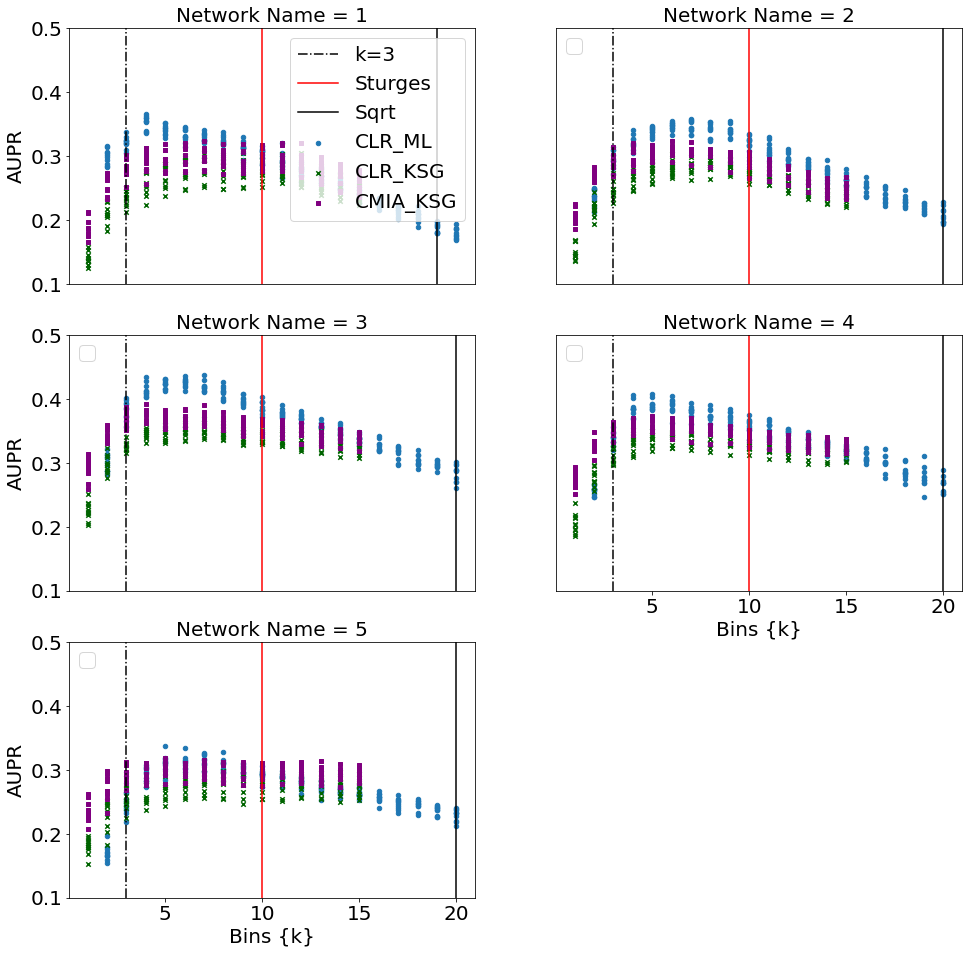

In [7]:
### Plot by network size == 100
matplotlib.rcParams.update({"figure.figsize": (16,16)})

### Constants
#MI_list = ["ML","KSG"]
#Inference_list = ["CLR_v1","CLRvMinet","CMIA_CLR","CMIA_CLR_vKSG"]
AUPR_min = 0.1
n1_g100_data_pts = 393
n2_g100_data_pts = 401
n3_g100_data_pts = 401
n4_g100_data_pts = 401
n5_g100_data_pts = 401

ax1 = plt.subplot(3,2,1)
### Removing some MI estimators and Inference-algo
#rslt_df = df[(df['Network Size']==100) & (df['Network Name']=="1") & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==1) & (df["MI-est"] == "ML") & (df["Inf-algo"] == "CLRvMinet")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", label="CLR_ML", ax=ax1)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==1) & (df["MI-est"] == "KSG") & (df["Inf-algo"] == "CLRvMinet")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", c='DarkGreen', marker = "x",label = "CLR_KSG", ax=ax1)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==1) & (df["MI-est"] == "KSG") & (df["Inf-algo"] == "CMIA_CLR_vKSG")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", c='Purple', marker = "s",label = "CMIA_KSG", ax=ax1)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)

ax1.set_ylim(AUPR_min, 0.5); ax1.set_ylabel('AUPR')
ax1.set_xticks([]); ax1.set_xlabel('')
ax1.axvline(x=3, color='k', linestyle='dashdot',label='k=3')
ax1.axvline(x=np.ceil(np.log2(n1_g100_data_pts)+1), color='r', label='Sturges')
ax1.axvline(x=np.floor(n1_g100_data_pts**(1/2)), color='k', label='Sqrt')
ax1.set_title("Network Name = 1")
ax1.legend()

ax2 = plt.subplot(3,2,2)
# Removing some MI estimators and Inference-algo
#rslt_df = df[(df['Network Size']==100) & (df['Network Name']=="2") & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==2) & (df["MI-est"] == "ML") & (df["Inf-algo"]== "CLRvMinet")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", label="CLR_ML", ax=ax2)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==2) & (df["MI-est"] == "KSG") & (df["Inf-algo"]== "CLRvMinet")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", c='DarkGreen', marker = "x",label = "CLR_KSG", ax=ax2)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==2) & (df["MI-est"] == "KSG") & (df["Inf-algo"] == "CMIA_CLR_vKSG")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", c='Purple', marker = "s",label = "CMIA_KSG", ax=ax2)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)

ax2.set_ylim(AUPR_min, 0.5); ax2.set_ylabel(''); ax2.set_yticks([])
ax2.set_xticks([]); ax2.set_xlabel('')
ax2.axvline(x=3, color='k', linestyle='dashdot',label='k=3')
ax2.axvline(x=np.ceil(np.log2(n2_g100_data_pts)+1), color='r', label='Sturges')
ax2.axvline(x=np.floor(n2_g100_data_pts**(1/2)), color='k', label='Sqrt')
ax2.set_title("Network Name = 2")
ax2.legend('')

ax3 = plt.subplot(3,2,3)
# Removing some MI estimators and Inference-algo
#rslt_df = df[(df['Network Size']==100) & (df['Network Name']=="3") & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==3) & (df["MI-est"] == "ML") & (df["Inf-algo"]== "CLRvMinet")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", label="CLR_ML", ax=ax3)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==3) & (df["MI-est"] == "KSG") & (df["Inf-algo"]== "CLRvMinet")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", c='DarkGreen', marker = "x",label = "CLR_KSG", ax=ax3)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==3) & (df["MI-est"] == "KSG") & (df["Inf-algo"] == "CMIA_CLR_vKSG")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", c='Purple', marker = "s",label = "CMIA_KSG", ax=ax3)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)

ax3.set_ylim(AUPR_min, 0.5); ax3.set_ylabel('AUPR')
ax3.set_xticks([]); ax3.set_xlabel('')
ax3.axvline(x=3, color='k', linestyle='dashdot',label='k=3')
ax3.axvline(x=np.ceil(np.log2(n3_g100_data_pts)+1), color='r', label='Sturges')
ax3.axvline(x=np.floor(n3_g100_data_pts**(1/2)), color='k', label='Sqrt')
ax3.set_title("Network Name = 3")
ax3.legend('')

ax4 = plt.subplot(3,2,4)
# Removing some MI estimators and Inference-algo
#rslt_df = df[(df['Network Size']==100) & (df['Network Name']=="4") & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==4) & (df["MI-est"] == "ML") & (df["Inf-algo"]== "CLRvMinet")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", label="CLR_ML", ax=ax4)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==4) & (df["MI-est"] == "KSG") & (df["Inf-algo"]== "CLRvMinet")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", c='DarkGreen', marker = "x",label = "CLR_KSG", ax=ax4)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==4) & (df["MI-est"] == "KSG") & (df["Inf-algo"] == "CMIA_CLR_vKSG")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", c='Purple', marker = "s",label = "CMIA_KSG", ax=ax4)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)

ax4.set_ylim(AUPR_min, 0.5); ax4.set_ylabel(''); ax4.set_yticks([])
ax4.axvline(x=3, color='k', linestyle='dashdot',label='k=3')
ax4.axvline(x=np.ceil(np.log2(n4_g100_data_pts)+1), color='r', label='Sturges')
ax4.axvline(x=np.floor(n4_g100_data_pts**(1/2)), color='k', label='Sqrt')
ax4.set_title("Network Name = 4")
ax4.legend('')

ax5 = plt.subplot(3,2,5)
# Removing some MI estimators and Inference-algo
#rslt_df = df[(df['Network Size']==100) & (df['Network Name']=="5") & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==5) & (df["MI-est"] == "ML") & (df["Inf-algo"]== "CLRvMinet")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", label="CLR_ML", ax=ax5)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==5) & (df["MI-est"] == "KSG") & (df["Inf-algo"]== "CLRvMinet")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", c='DarkGreen', marker = "x",label = "CLR_KSG", ax=ax5)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)
rslt_df = df[(df['Network Size']==100) & (df['Network Name']==5) & (df["MI-est"] == "KSG") & (df["Inf-algo"] == "CMIA_CLR_vKSG")]  
rslt_df.plot.scatter(x = "Bins {k}", y = "AUPR", c='Purple', marker = "s",label = "CMIA_KSG", ax=ax5)#, rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)

ax5.set_ylim(AUPR_min, 0.5); ax5.set_ylabel('AUPR')
ax5.axvline(x=3, color='k', linestyle='dashdot',label='k=3')
ax5.axvline(x=np.ceil(np.log2(n5_g100_data_pts)+1), color='r', label='Sturges')
ax5.axvline(x=np.floor(n5_g100_data_pts**(1/2)), color='k', label='Sqrt')
ax5.set_title("Network Name = 5")
ax5.legend('')

plt.suptitle('')

plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

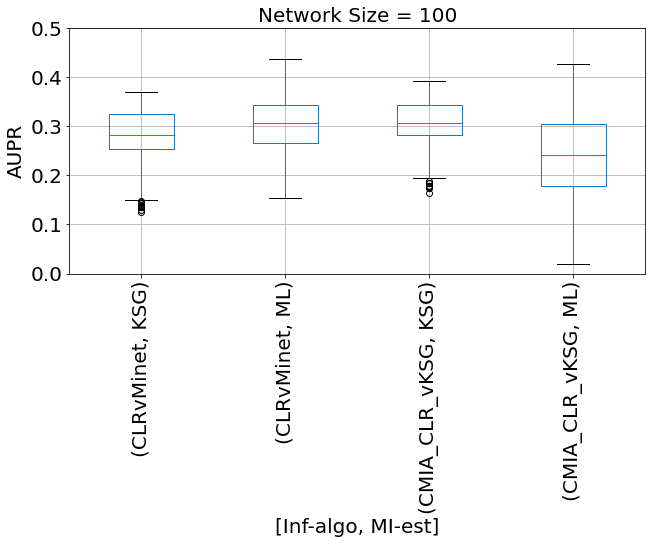

In [8]:
### Plot by network size of all kNN and bins
matplotlib.rcParams.update({"figure.figsize": (10,10)})

"""conditions = [50,100]

for counter,condition in enumerate(conditions):
    plt.subplot(2,1,counter+1)
    rslt_df = df[df['Network Size'].isin([condition])] 
    #ax = rslt_df.boxplot(column=["inf-algo","MI-est"],by="AUPR", rot=90, return_type='axes')
    ax = rslt_df.boxplot(column=["AUPR"],by="Inf_algo+Mi_est", layout=(1, 1),rot=90, return_type='axes')

    ax.set_ylim(0, 0.5)
    if counter == 0 or counter == 1:
        ax.set_xticks([]) #ax.set_xlabel('')
    #plt.title(condition)
"""

MI_list = ["ML","KSG"]
Inference_list = ["CLR_v1","CLRvMinet","CMIA_CLR","CMIA_CLR_vKSG"]

"""ax1 = plt.subplot(2,1,1)
#rslt_df = df[df['Network Size']==50] 
# Removing some MI estimators and Inference-algo

rslt_df = df[(df['Network Size']==10) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
#rslt_df = df[(df['Network Size']==50) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
rslt_df.boxplot(column=["AUPR"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)

ax1.set_ylim(0, 0.5); ax1.set_ylabel('AUPR')
ax1.set_xticks([]); ax1.set_xlabel('')
#ax1.set_title("Network Size = 10")
ax1.set_title("Network Size = 50")"""

ax2 = plt.subplot(2,1,2)
#rslt_df = df[df['Network Size']==100] 
# Removing some MI estimators and Inference-algo
#rslt_df = df[(df['Network Size']==100) & (df["MI-est"]=="KSG")] 
rslt_df = df[(df['Network Size']==100) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  

rslt_df.boxplot(column=["AUPR"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax2)#, showmeans=True, meanline=False)

ax2.set_ylim(0, 0.5); ax2.set_ylabel('AUPR')
ax2.set_title("Network Size = 100")

plt.suptitle('')

plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

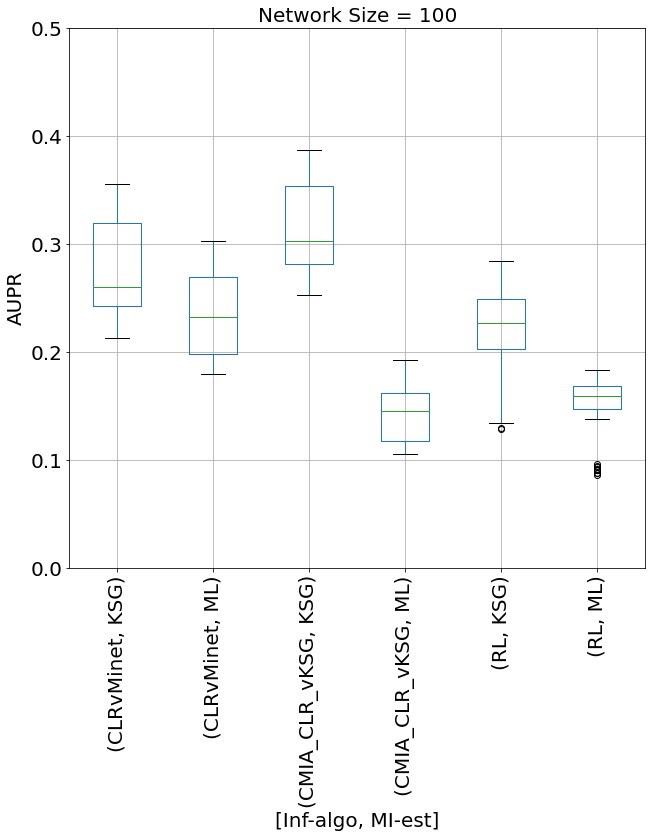

In [9]:
### Plot by network size of kNN = 3  and bins = sqrt
matplotlib.rcParams.update({"figure.figsize": (10,10)})

# backing up df
df_backup = df.copy()
# Selecting k =3 and bins = floor(sqrt(data)) same as Minet
df = df[~((df['Bins {k}'] != 3) & (df["MI-est"] == "KSG"))]  
df = df[~((df['Network Size']==100) & (df["MI-est"] == "ML") & (df["Network Name"] == 1) & (df['Bins {k}'] != np.floor(n1_g100_data_pts**(1/2))))]  
df = df[~((df['Network Size']==100) & (df["MI-est"] == "ML") & (df["Network Name"] == 2) & (df['Bins {k}'] != np.floor(n2_g100_data_pts**(1/2))))]
df = df[~((df['Network Size']==100) & (df["MI-est"] == "ML") & (df["Network Name"] == 3) & (df['Bins {k}'] != np.floor(n3_g100_data_pts**(1/2))))]
df = df[~((df['Network Size']==100) & (df["MI-est"] == "ML") & (df["Network Name"] == 4) & (df['Bins {k}'] != np.floor(n4_g100_data_pts**(1/2))))]
df = df[~((df['Network Size']==100) & (df["MI-est"] == "ML") & (df["Network Name"] == 5) & (df['Bins {k}'] != np.floor(n5_g100_data_pts**(1/2))))]
df = df[~(df['Network Size']== 10)] # For DREAM3 no need for network size 10

"""conditions = [50,100]

for counter,condition in enumerate(conditions):
    plt.subplot(2,1,counter+1)
    rslt_df = df[df['Network Size'].isin([condition])] 
    #ax = rslt_df.boxplot(column=["inf-algo","MI-est"],by="AUPR", rot=90, return_type='axes')
    ax = rslt_df.boxplot(column=["AUPR"],by="Inf_algo+Mi_est", layout=(1, 1),rot=90, return_type='axes')

    ax.set_ylim(0, 0.5)
    if counter == 0 or counter == 1:
        ax.set_xticks([]) #ax.set_xlabel('')
    #plt.title(condition)
"""

# Removing some MI estimators and Inference-algo
MI_list = ["ML","KSG"]
Inference_list = ["RL","CLRvMinet","CMIA_CLR","CMIA_CLR_vKSG"]

ax2 = plt.subplot(1,1,1)
#rslt_df = df[df['Network Size']==100] 
# Removing some MI estimators and Inference-algo
#rslt_df = df[(df['Network Size']==100) & (df["MI-est"]=="KSG")] 
rslt_df = df[(df['Network Size']==100) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  

rslt_df.boxplot(column=["AUPR"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax2)#, showmeans=True, meanline=False)

ax2.set_ylim(0, 0.5); ax2.set_ylabel('AUPR')
ax2.set_title("Network Size = 100")

plt.suptitle('')

plt.tight_layout

# restoring DF to origianl
#df = df_backup.copy()

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

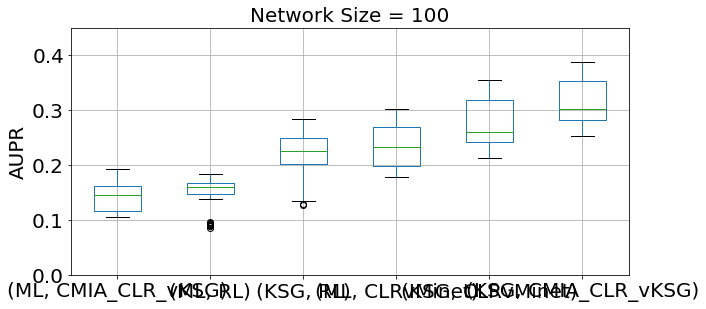

In [10]:
### Displaying the median AUPR in Ascending order  
matplotlib.rcParams.update({"figure.figsize": (10,10)})

ax2 = plt.subplot(2,1,2)
# Removing some MI estimators and Inference-algo
rslt_df = df[(df['Network Size']==100) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot()
#rslt_df.boxplot(column=["AUPR"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax2)#, showmeans=True, meanline=False)

ax2.set_ylim(0, 0.45); ax2.set_ylabel('AUPR')
ax2.set_title("Network Size = 100")

plt.suptitle('')

plt.tight_layout

In [11]:
df.groupby(["Network Size","Inf-algo","MI-est"]).count() #mean()

AUPR  Network Name  Data Type  Bins {k}  \
Network Size Inf-algo      MI-est                                            
100          CLRvMinet     KSG       50            50         50        50   
                           ML        50            50         50        50   
                           MM        50            50         50        50   
             CMIA_CLR_vKSG KSG       50            50         50        50   
                           ML        50            50         50        50   
                           MM        50            50         50        50   
             RL            KSG       50            50         50        50   
                           ML        50            50         50        50   
                           MM        50            50         50        50   

                                   Replicate  
Network Size Inf-algo      MI-est             
100          CLRvMinet     KSG            50  
                           ML             50  
                           MM             50  
             CMIA_CLR_vKSG KSG            50  
                           ML             50  
                           MM             50  
             RL            KSG            50  
                           ML             50  
                           MM             50

In [12]:
# 2021-04-27: Adding AUPR improvement relative to [CLR, ML]
#df["AUPR_relative"] = df["AUPR"]-df["AUPR"][]
#df[(df["Inf-algo"] == "CLR") & (df["MI-est"] == "ML") & (df["Network Size"] == 50) & (df["Network Name"] == "Yeast2")]

for net_name in df["Network Name"].unique():
    print(net_name)
    #rslt_df = df[df["Network Name"] == net_name]
    #for net_size in rslt_df["Network Size"].unique():
    for net_size in df["Network Size"].unique():
        print(net_size)
        #rslt_df = rslt_df[rslt_df["Network Size"] == net_size]
        #for rep in rslt_df.Replicate.unique():
        for rep in df.Replicate.unique():
            print(rep)
            #rslt_df = rslt_df[rslt_df["Replicate"] == rep]
            rslt_df = df[(df["Replicate"] == rep) & (df["Network Size"] == net_size) & (df["Network Name"] == net_name)]
            #print(df[(df["Inf-algo"] == "CLR") & (df["MI-est"] == "ML") & (df["Replicate"] == rep) & (df["Network Size"] == net_size) & (df["Network Name"] == net_name)].AUPR)
            #print(rslt_df.AUPR - rslt_df[(rslt_df["Inf-algo"] == "CLR") & (rslt_df["MI-est"] == "ML")].AUPR)
            AUPR_value_to_compare = float(rslt_df[(rslt_df["Inf-algo"] == "CLRvMinet") & (rslt_df["MI-est"] == "ML")].AUPR)
            print((rslt_df.AUPR - AUPR_value_to_compare)/AUPR_value_to_compare*100)
            df.loc[rslt_df.index, ('AUPR_relative')] = (rslt_df.AUPR - AUPR_value_to_compare)/AUPR_value_to_compare*100

df['AUPR_relative'] = df['AUPR_relative'].fillna(0)

3
100
rep_8
80      0.000000
111    20.000000
124    -0.370370
125   -24.074074
126   -29.259259
139    34.074074
142    14.444444
143   -38.148148
162   -38.888889
Name: AUPR, dtype: float64
rep_4
163     0.000000
194    14.930556
207    -1.388889
208   -25.000000
209   -31.944444
222    30.902778
225    11.111111
226   -41.666667
245   -41.666667
Name: AUPR, dtype: float64
rep_1
246     0.000000
277    19.127517
290   -10.067114
291   -30.872483
292   -29.530201
305    29.865772
308    14.429530
309   -39.932886
328   -44.630872
Name: AUPR, dtype: float64
rep_7
329     0.000000
360    21.072797
373     4.214559
374   -23.754789
375   -29.885057
388    40.229885
391    14.559387
392   -37.931034
411   -39.463602
Name: AUPR, dtype: float64
rep_3
412     0.000000
443    13.494810
456    -3.460208
457   -27.335640
458   -30.449827
471    28.719723
474    10.726644
475   -38.754325
494   -41.522491
Name: AUPR, dtype: float64
rep_2
495     0.000000
526    12.913907
539   -10.264901
540   -

Name: AUPR, dtype: float64
rep_9
4174   -11.524164
4175     0.000000
4194   -45.724907
4220    20.446097
4250    35.315985
4253   -29.368030
4254   -40.892193
4255   -35.315985
4256    13.382900
Name: AUPR, dtype: float64
rep_6
4257   -11.895911
4258     0.000000
4277   -40.148699
4303    13.754647
4333    29.739777
4336   -23.420074
4337   -34.572491
4338   -30.111524
4339    13.382900
Name: AUPR, dtype: float64


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

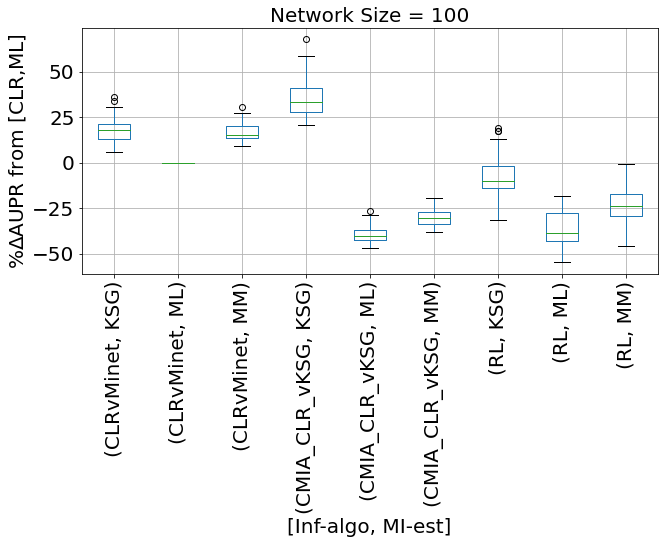

In [13]:
### Plot by network size
matplotlib.rcParams.update({"figure.figsize": (10,10)})

"""ax1 = plt.subplot(2,1,1)
rslt_df = df[df['Network Size']==50] 
#rslt_df = df[df['Network Size']==10] 
rslt_df.boxplot(column=["AUPR_relative"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)

ax1.set_ylabel(r'%$\Delta$AUPR from [CLR,ML]'); #ax1.set_ylim(0, 0.4); 
ax1.set_xticks([]); ax1.set_xlabel('')
ax1.set_title("Network Size = 50")
#ax1.set_title("Network Size = 10")
"""
ax2 = plt.subplot(2,1,2)
rslt_df = df[df['Network Size']==100] 
rslt_df.boxplot(column=["AUPR_relative"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax2)#, showmeans=True, meanline=False)

ax2.set_ylabel(r'%$\Delta$AUPR from [CLR,ML]'); #ax2.set_ylim(0, 0.4); 
ax2.set_title("Network Size = 100")

plt.suptitle('')

plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

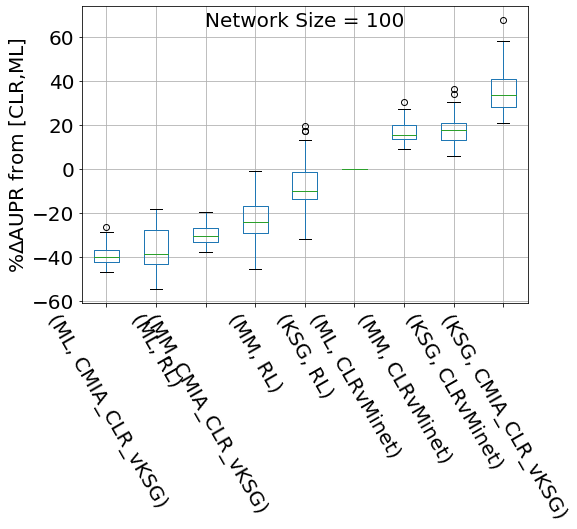

In [14]:
### Plot by network size
matplotlib.rcParams.update({"figure.figsize": (8,12)})

# constants
label_rotation = -60
title_pad = -20

# Removing some MI estimators and Inference-algo
MI_list = ["ML","MM","KSG"]
Inference_list = ["RL","CLRvMinet","CMIA_CLR_vKSG"]

"""ax1 = plt.subplot(2,1,1)
rslt_df = df[(df['Network Size']==10) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR_relative'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot(rot=label_rotation)
#rslt_df.boxplot(column=["AUPR_relative"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax1)#, showmeans=True, meanline=False)

ax1.set_ylabel(r'%$\Delta$AUPR from [CLR,ML]'); #ax1.set_ylim(0, 0.4); 
#ax1.set_xticks([]); ax1.set_xlabel('')
ax1.set_title("Network Size = 10", y=1.0, pad=title_pad)"""

ax2 = plt.subplot(2,1,2)
# Removing some MI estimators and Inference-algo
rslt_df = df[(df['Network Size']==100) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR_relative'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot(rot=label_rotation)
#rslt_df.boxplot(column=["AUPR_relative"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax2)#, showmeans=True, meanline=False)

ax2.set_ylabel(r'%$\Delta$AUPR from [CLR,ML]'); #ax2.set_ylim(0, 0.4); 
ax2.set_title("Network Size = 100", y=1.0, pad=title_pad)

plt.suptitle('')

plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

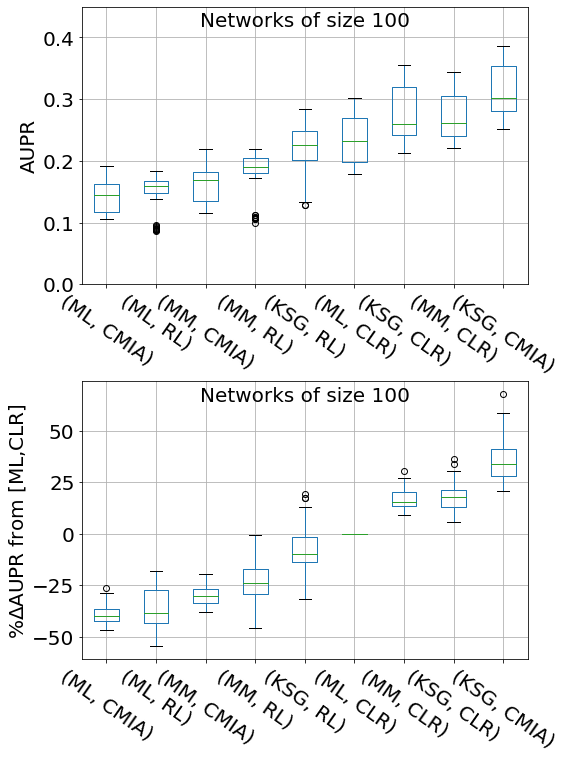

In [15]:
### Plotting all 2 subplots in one figure
matplotlib.rcParams.update({"figure.figsize": (8,12)})

# constants
label_rotation = -35
title_pad = -20
y_lim_high = 55 #80
y_lim_low = -60 #-60

# Removing some MI estimators and Inference-algo
df.replace({'Inf-algo' : { 'CMIA_CLR_vKSG' : 'CMIA', 'CLRvMinet' : 'CLR'}}, inplace=True)

MI_list = ["ML","MM","KSG"]
#Inference_list = ["RL","CLR","SA_CLR"]
Inference_list = ["RL","CLR","CMIA"]

"""ax2 = plt.subplot(2,2,2)
# Removing some MI estimators and Inference-algo
rslt_df = df[(df['Network Size']==100) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR_relative'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot(rot=label_rotation)
#rslt_df.boxplot(column=["AUPR_relative"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax2)#, showmeans=True, meanline=False)

ax2.set_ylabel(r'%$\Delta$AUPR from [CLR,ML]'); ax2.set_ylim(y_lim_low, y_lim_high); 
ax2.set_ylabel(''); ax2.set_yticklabels([]); #ax2.set_yticks([]);
ax2.set_title("Network Size = 100", y=1.0, pad=title_pad)
#ax2.tick_params(axis='x',labelrotation=rotation)
"""
###############

ax2 = plt.subplot(2,1,1)
# Removing some MI estimators and Inference-algo
rslt_df = df[(df['Network Size']==100) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot(rot=label_rotation)
#rslt_df.boxplot(column=["AUPR"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax2)#, showmeans=True, meanline=False)

ax2.set_ylim(0, 0.45); ax2.set_ylabel('AUPR')
ax2.set_title("Networks of size 100", y=1.0, pad=title_pad)

###################
ax4 = plt.subplot(2,1,2)
# Removing some MI estimators and Inference-algo
rslt_df = df[(df['Network Size']==100) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR_relative'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot(rot=label_rotation)
#rslt_df.boxplot(column=["AUPR_relative"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax2)#, showmeans=True, meanline=False)

ax4.set_ylabel(r'%$\Delta$AUPR from [ML,CLR]'); #ax2.set_ylim(0, 0.4); 
ax4.set_title("Networks of size 100", y=1.0, pad=title_pad)

##############

plt.subplots_adjust(hspace=0.35) #left=None, bottom=None, right=None, top=None, wspace=None, hspace=None

plt.suptitle('')

plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

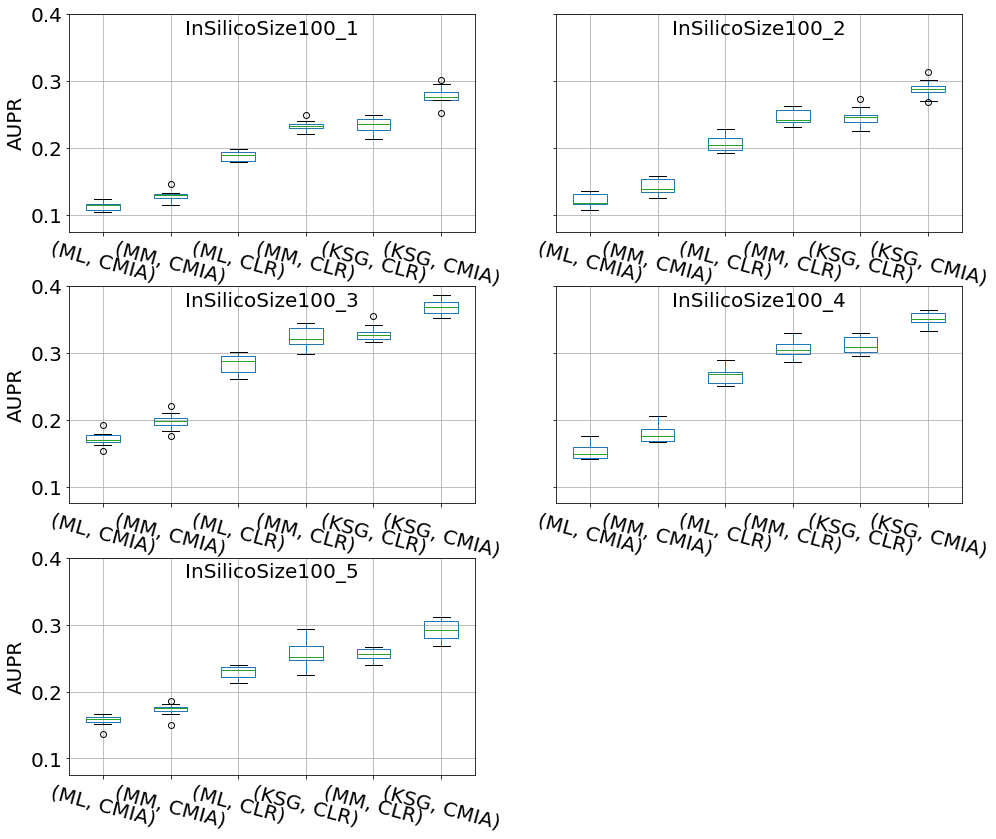

In [16]:
### 2021-10-02: Plotting the 4 Ecoli networks

# Removing some MI estimators and Inference-algo
MI_list = ["ML","MM","KSG"]
Inference_list = ["CLR","CMIA"]

### Plotting all 4 subplots in one figure
matplotlib.rcParams.update({"figure.figsize": (16,14)})

#Contants
title_pad = -20
rotation = -15
max_y = 0.4 #0.435
min_y = 0.075 #0

ax1 = plt.subplot(3,2,1)

rslt_df = df[(df['Network Name']==1) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot()

ax1.set_ylim(min_y, max_y); ax1.set_ylabel('AUPR')
#ax1.set_xticks([]); ax1.set_xlabel('')
ax1.set_title("InSilicoSize100_1", y=1.0, pad=title_pad)
ax1.tick_params(axis='x',labelrotation=rotation)

ax2 = plt.subplot(3,2,2)
# Removing some MI estimators and Inference-algo
rslt_df = df[(df['Network Name']==2) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot()
#rslt_df.boxplot(column=["AUPR"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax2)#, showmeans=True, meanline=False)

ax2.set_ylim(min_y, max_y); ax2.set_ylabel('AUPR')
ax2.set_ylabel(''); ax2.set_yticklabels([]); #ax2.set_yticks([]);
ax2.set_title("InSilicoSize100_2", y=1.0, pad=title_pad)
ax2.tick_params(axis='x',labelrotation=rotation)

ax3 = plt.subplot(3,2,3)

rslt_df = df[(df['Network Name']==3) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot()

ax3.set_ylim(min_y, max_y); ax3.set_ylabel('AUPR')
#ax3.set_yticks([]); ax3.set_ylabel('')
#ax1.set_xticks([]); ax1.set_xlabel('')
ax3.set_title("InSilicoSize100_3", y=1.0, pad=title_pad)
ax3.tick_params(axis='x',labelrotation=rotation)

ax4 = plt.subplot(3,2,4)
# Removing some MI estimators and Inference-algo
rslt_df = df[(df['Network Name']==4) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot()
#rslt_df.boxplot(column=["AUPR"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax2)#, showmeans=True, meanline=False)

ax4.set_ylim(min_y, max_y); ax4.set_ylabel('AUPR')
ax4.set_ylabel(''); ax4.set_yticklabels([]); #ax4.set_yticks([]);
ax4.set_title("InSilicoSize100_4", y=1.0, pad=title_pad)
ax4.tick_params(axis='x',labelrotation=rotation)

ax5 = plt.subplot(3,2,5)
# Removing some MI estimators and Inference-algo
rslt_df = df[(df['Network Name']==5) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot()
#rslt_df.boxplot(column=["AUPR"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax2)#, showmeans=True, meanline=False)

ax5.set_ylim(min_y, max_y); ax5.set_ylabel('AUPR')
#ax5.set_ylabel(''); ax5.set_yticklabels([]); #ax5.set_yticks([]);
ax5.set_title("InSilicoSize100_5", y=1.0, pad=title_pad)
ax5.tick_params(axis='x',labelrotation=rotation)

plt.subplots_adjust(hspace=0.25) #left=None, bottom=None, right=None, top=None, wspace=None, hspace=None

plt.suptitle('')

plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

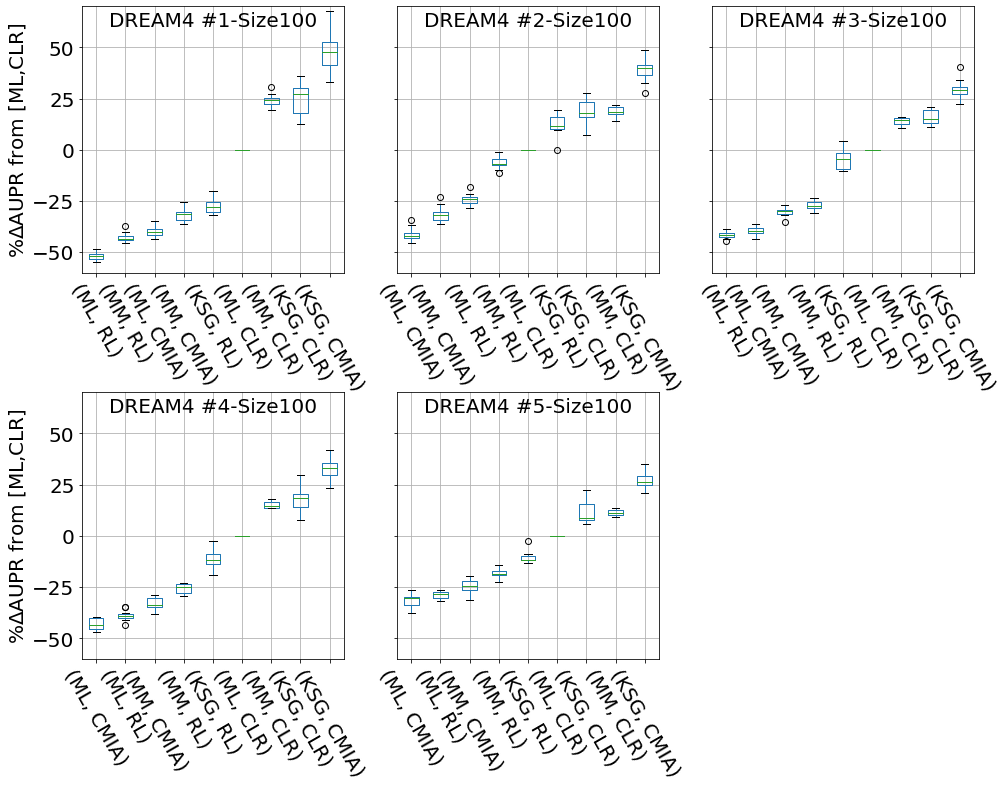

In [22]:
### 2021-10-02: Plotting the 4 Ecoli networks

# Removing some MI estimators and Inference-algo
MI_list = ["ML","MM","KSG"]
Inference_list = ["RL","CLR","CMIA"]

### Plotting all 4 subplots in one figure
matplotlib.rcParams.update({"figure.figsize": (16,12)})

#Contants
title_pad = -20
rotation = -60
y_lim_high = 70 #80
y_lim_low = -60 #-60

ax1 = plt.subplot(2,3,1)

rslt_df = df[(df['Network Name']==1) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR_relative'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot()

ax1.set_ylim(y_lim_low, y_lim_high); ax1.set_ylabel(r'%$\Delta$AUPR from [ML,CLR]')
#ax1.set_xticks([]); ax1.set_xlabel('')
ax1.set_title("DREAM4 #1-Size100", y=1.0, pad=title_pad)
ax1.tick_params(axis='x',labelrotation=rotation)

ax2 = plt.subplot(2,3,2)
# Removing some MI estimators and Inference-algo
rslt_df = df[(df['Network Name']==2) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR_relative'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot()
#rslt_df.boxplot(column=["AUPR"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax2)#, showmeans=True, meanline=False)

ax2.set_ylim(y_lim_low, y_lim_high); ax2.set_ylabel(r'%$\Delta$AUPR from [ML,CLR]')
ax2.set_ylabel(''); ax2.set_yticklabels([]); #ax2.set_yticks([]);
ax2.set_title("DREAM4 #2-Size100", y=1.0, pad=title_pad)
ax2.tick_params(axis='x',labelrotation=rotation)

ax3 = plt.subplot(2,3,3)

rslt_df = df[(df['Network Name']==3) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR_relative'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot()

ax3.set_ylim(y_lim_low, y_lim_high); ax3.set_ylabel(r'%$\Delta$AUPR from [ML,CLR]')
ax3.set_ylabel(''); ax3.set_yticklabels([]); #ax3.set_yticks([]);
#ax1.set_xticks([]); ax1.set_xlabel('')
ax3.set_title("DREAM4 #3-Size100", y=1.0, pad=title_pad)
ax3.tick_params(axis='x',labelrotation=rotation)

ax4 = plt.subplot(2,3,4)
# Removing some MI estimators and Inference-algo
rslt_df = df[(df['Network Name']==4) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR_relative'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot()
#rslt_df.boxplot(column=["AUPR"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax2)#, showmeans=True, meanline=False)

ax4.set_ylim(y_lim_low, y_lim_high); ax4.set_ylabel(r'%$\Delta$AUPR from [ML,CLR]')
#ax4.set_ylabel(''); ax4.set_yticklabels([]); #ax4.set_yticks([]);
ax4.set_title("DREAM4 #4-Size100", y=1.0, pad=title_pad)
ax4.tick_params(axis='x',labelrotation=rotation)

ax5 = plt.subplot(2,3,5)
# Removing some MI estimators and Inference-algo
rslt_df = df[(df['Network Name']==5) & (df["MI-est"].isin(MI_list)) & (df["Inf-algo"].isin(Inference_list))]  
grouped = rslt_df.groupby(["MI-est", "Inf-algo"])
df2 = pd.DataFrame({col:vals['AUPR_relative'] for col,vals in grouped})

meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]
df2.boxplot()
#rslt_df.boxplot(column=["AUPR"],by=["Inf-algo","MI-est"], rot=90, return_type='axes', ax=ax2)#, showmeans=True, meanline=False)

ax5.set_ylim(y_lim_low, y_lim_high); ax5.set_ylabel(r'%$\Delta$AUPR from [ML,CLR]')
ax5.set_ylabel(''); ax5.set_yticklabels([]); #ax5.set_yticks([]);
ax5.set_title("DREAM4 #5-Size100", y=1.0, pad=title_pad)
ax5.tick_params(axis='x',labelrotation=rotation)

plt.subplots_adjust(hspace=0.45) #left=None, bottom=None, right=None, top=None, wspace=None, hspace=None

plt.suptitle('')

plt.tight_layout

In [27]:
### DRAFT

In [32]:
a = [100,200,300,400,500]
for item in a:
    print(np.ceil(item**(1/3)),np.ceil(np.log2(item)+1),np.ceil(item**(1/2)))

5.0 8.0 10.0
6.0 9.0 15.0
7.0 10.0 18.0
8.0 10.0 20.0
8.0 10.0 23.0


In [7]:
tmp_a = np.zeros(len(range(1)), dtype=float)
print(tmp_a.size)

1
